# Lyapunov Exponent Calculation

## Theoretical Background

The **Lyapunov exponent** is a fundamental quantity in dynamical systems theory that characterizes the rate of separation of infinitesimally close trajectories. It provides a quantitative measure of the sensitivity of a system to initial conditions—the hallmark of chaos.

### Definition

For a dynamical system described by:

$$\frac{d\mathbf{x}}{dt} = \mathbf{f}(\mathbf{x})$$

Consider two nearby trajectories $\mathbf{x}(t)$ and $\mathbf{x}(t) + \boldsymbol{\delta}(t)$, where $\boldsymbol{\delta}(t)$ is an infinitesimal perturbation. The evolution of this perturbation is governed by the linearized equation:

$$\frac{d\boldsymbol{\delta}}{dt} = \mathbf{J}(\mathbf{x}(t)) \cdot \boldsymbol{\delta}$$

where $\mathbf{J}(\mathbf{x}) = \frac{\partial \mathbf{f}}{\partial \mathbf{x}}$ is the Jacobian matrix.

### Maximal Lyapunov Exponent

The **maximal Lyapunov exponent** (MLE) $\lambda$ is defined as:

$$\lambda = \lim_{t \to \infty} \lim_{\|\boldsymbol{\delta}_0\| \to 0} \frac{1}{t} \ln \frac{\|\boldsymbol{\delta}(t)\|}{\|\boldsymbol{\delta}_0\|}$$

### Physical Interpretation

- $\lambda > 0$: **Chaotic behavior** — nearby trajectories diverge exponentially
- $\lambda = 0$: **Marginally stable** — perturbations neither grow nor decay
- $\lambda < 0$: **Stable behavior** — trajectories converge

### Numerical Algorithm

We employ the standard algorithm for computing the MLE:

1. Integrate the system equations along with the tangent space (variational) equations
2. Periodically renormalize the perturbation vector to prevent overflow
3. Accumulate the logarithm of the stretching factors

The MLE is computed as:

$$\lambda \approx \frac{1}{N \cdot \Delta t} \sum_{i=1}^{N} \ln \|\boldsymbol{\delta}_i\|$$

where $N$ is the number of renormalization steps and $\Delta t$ is the time interval between renormalizations.

## The Lorenz System

We will compute the Lyapunov exponent for the classic **Lorenz system**:

$$\begin{align}
\frac{dx}{dt} &= \sigma(y - x) \\
\frac{dy}{dt} &= x(\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{align}$$

With the classical parameters $\sigma = 10$, $\rho = 28$, $\beta = 8/3$, the Lorenz system exhibits chaotic behavior with a positive maximal Lyapunov exponent $\lambda \approx 0.9$.

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Lorenz system parameters
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

def lorenz(state, t):
    """Lorenz system equations."""
    x, y, z = state
    return [
        sigma * (y - x),
        x * (rho - z) - y,
        x * y - beta * z
    ]

def lorenz_jacobian(state):
    """Jacobian matrix of the Lorenz system."""
    x, y, z = state
    return np.array([
        [-sigma, sigma, 0],
        [rho - z, -1, -x],
        [y, x, -beta]
    ])

def lorenz_with_tangent(state, t):
    """Combined system: Lorenz equations + tangent space evolution."""
    # Main state variables
    xyz = state[:3]
    # Tangent vector (perturbation)
    delta = state[3:6]
    
    # Lorenz equations
    dxyz = lorenz(xyz, t)
    
    # Tangent space evolution: d(delta)/dt = J * delta
    J = lorenz_jacobian(xyz)
    ddelta = J @ delta
    
    return np.concatenate([dxyz, ddelta])

## Lyapunov Exponent Computation

We now implement the algorithm to compute the maximal Lyapunov exponent using periodic renormalization of the tangent vector.

In [2]:
def compute_lyapunov_exponent(initial_state, t_transient, t_compute, dt_renorm, dt_integrate):
    """
    Compute the maximal Lyapunov exponent for the Lorenz system.
    
    Parameters:
    -----------
    initial_state : array
        Initial condition [x0, y0, z0]
    t_transient : float
        Transient time to reach the attractor
    t_compute : float
        Total time for Lyapunov exponent computation
    dt_renorm : float
        Time interval between renormalizations
    dt_integrate : float
        Integration time step
    
    Returns:
    --------
    lyapunov_exponent : float
        Estimated maximal Lyapunov exponent
    lyapunov_history : array
        Running estimate of the Lyapunov exponent
    """
    # Transient integration to reach the attractor
    t_trans = np.arange(0, t_transient, dt_integrate)
    trajectory = odeint(lorenz, initial_state, t_trans)
    state = trajectory[-1]
    
    # Initialize tangent vector (random direction, unit norm)
    delta = np.random.randn(3)
    delta = delta / np.linalg.norm(delta)
    
    # Combined state: [x, y, z, delta_x, delta_y, delta_z]
    combined_state = np.concatenate([state, delta])
    
    # Lyapunov exponent accumulation
    n_renorm = int(t_compute / dt_renorm)
    log_stretching = 0.0
    lyapunov_history = []
    
    for i in range(n_renorm):
        # Integrate for one renormalization period
        t_interval = np.arange(0, dt_renorm + dt_integrate, dt_integrate)
        result = odeint(lorenz_with_tangent, combined_state, t_interval)
        combined_state = result[-1]
        
        # Extract and renormalize tangent vector
        delta = combined_state[3:6]
        norm_delta = np.linalg.norm(delta)
        
        # Accumulate log of stretching
        log_stretching += np.log(norm_delta)
        
        # Renormalize
        combined_state[3:6] = delta / norm_delta
        
        # Running estimate of Lyapunov exponent
        current_time = (i + 1) * dt_renorm
        lyapunov_history.append(log_stretching / current_time)
    
    lyapunov_exponent = log_stretching / t_compute
    
    return lyapunov_exponent, np.array(lyapunov_history)

## Numerical Computation and Visualization

In [3]:
# Computation parameters
initial_state = [1.0, 1.0, 1.0]
t_transient = 50.0      # Time to reach attractor
t_compute = 1000.0      # Total computation time
dt_renorm = 1.0         # Renormalization interval
dt_integrate = 0.01     # Integration step

# Compute Lyapunov exponent
np.random.seed(42)
lambda_max, lambda_history = compute_lyapunov_exponent(
    initial_state, t_transient, t_compute, dt_renorm, dt_integrate
)

print(f"Maximal Lyapunov Exponent: λ = {lambda_max:.4f}")
print(f"Expected value (literature): λ ≈ 0.9056")

Maximal Lyapunov Exponent: λ = 0.9078
Expected value (literature): λ ≈ 0.9056


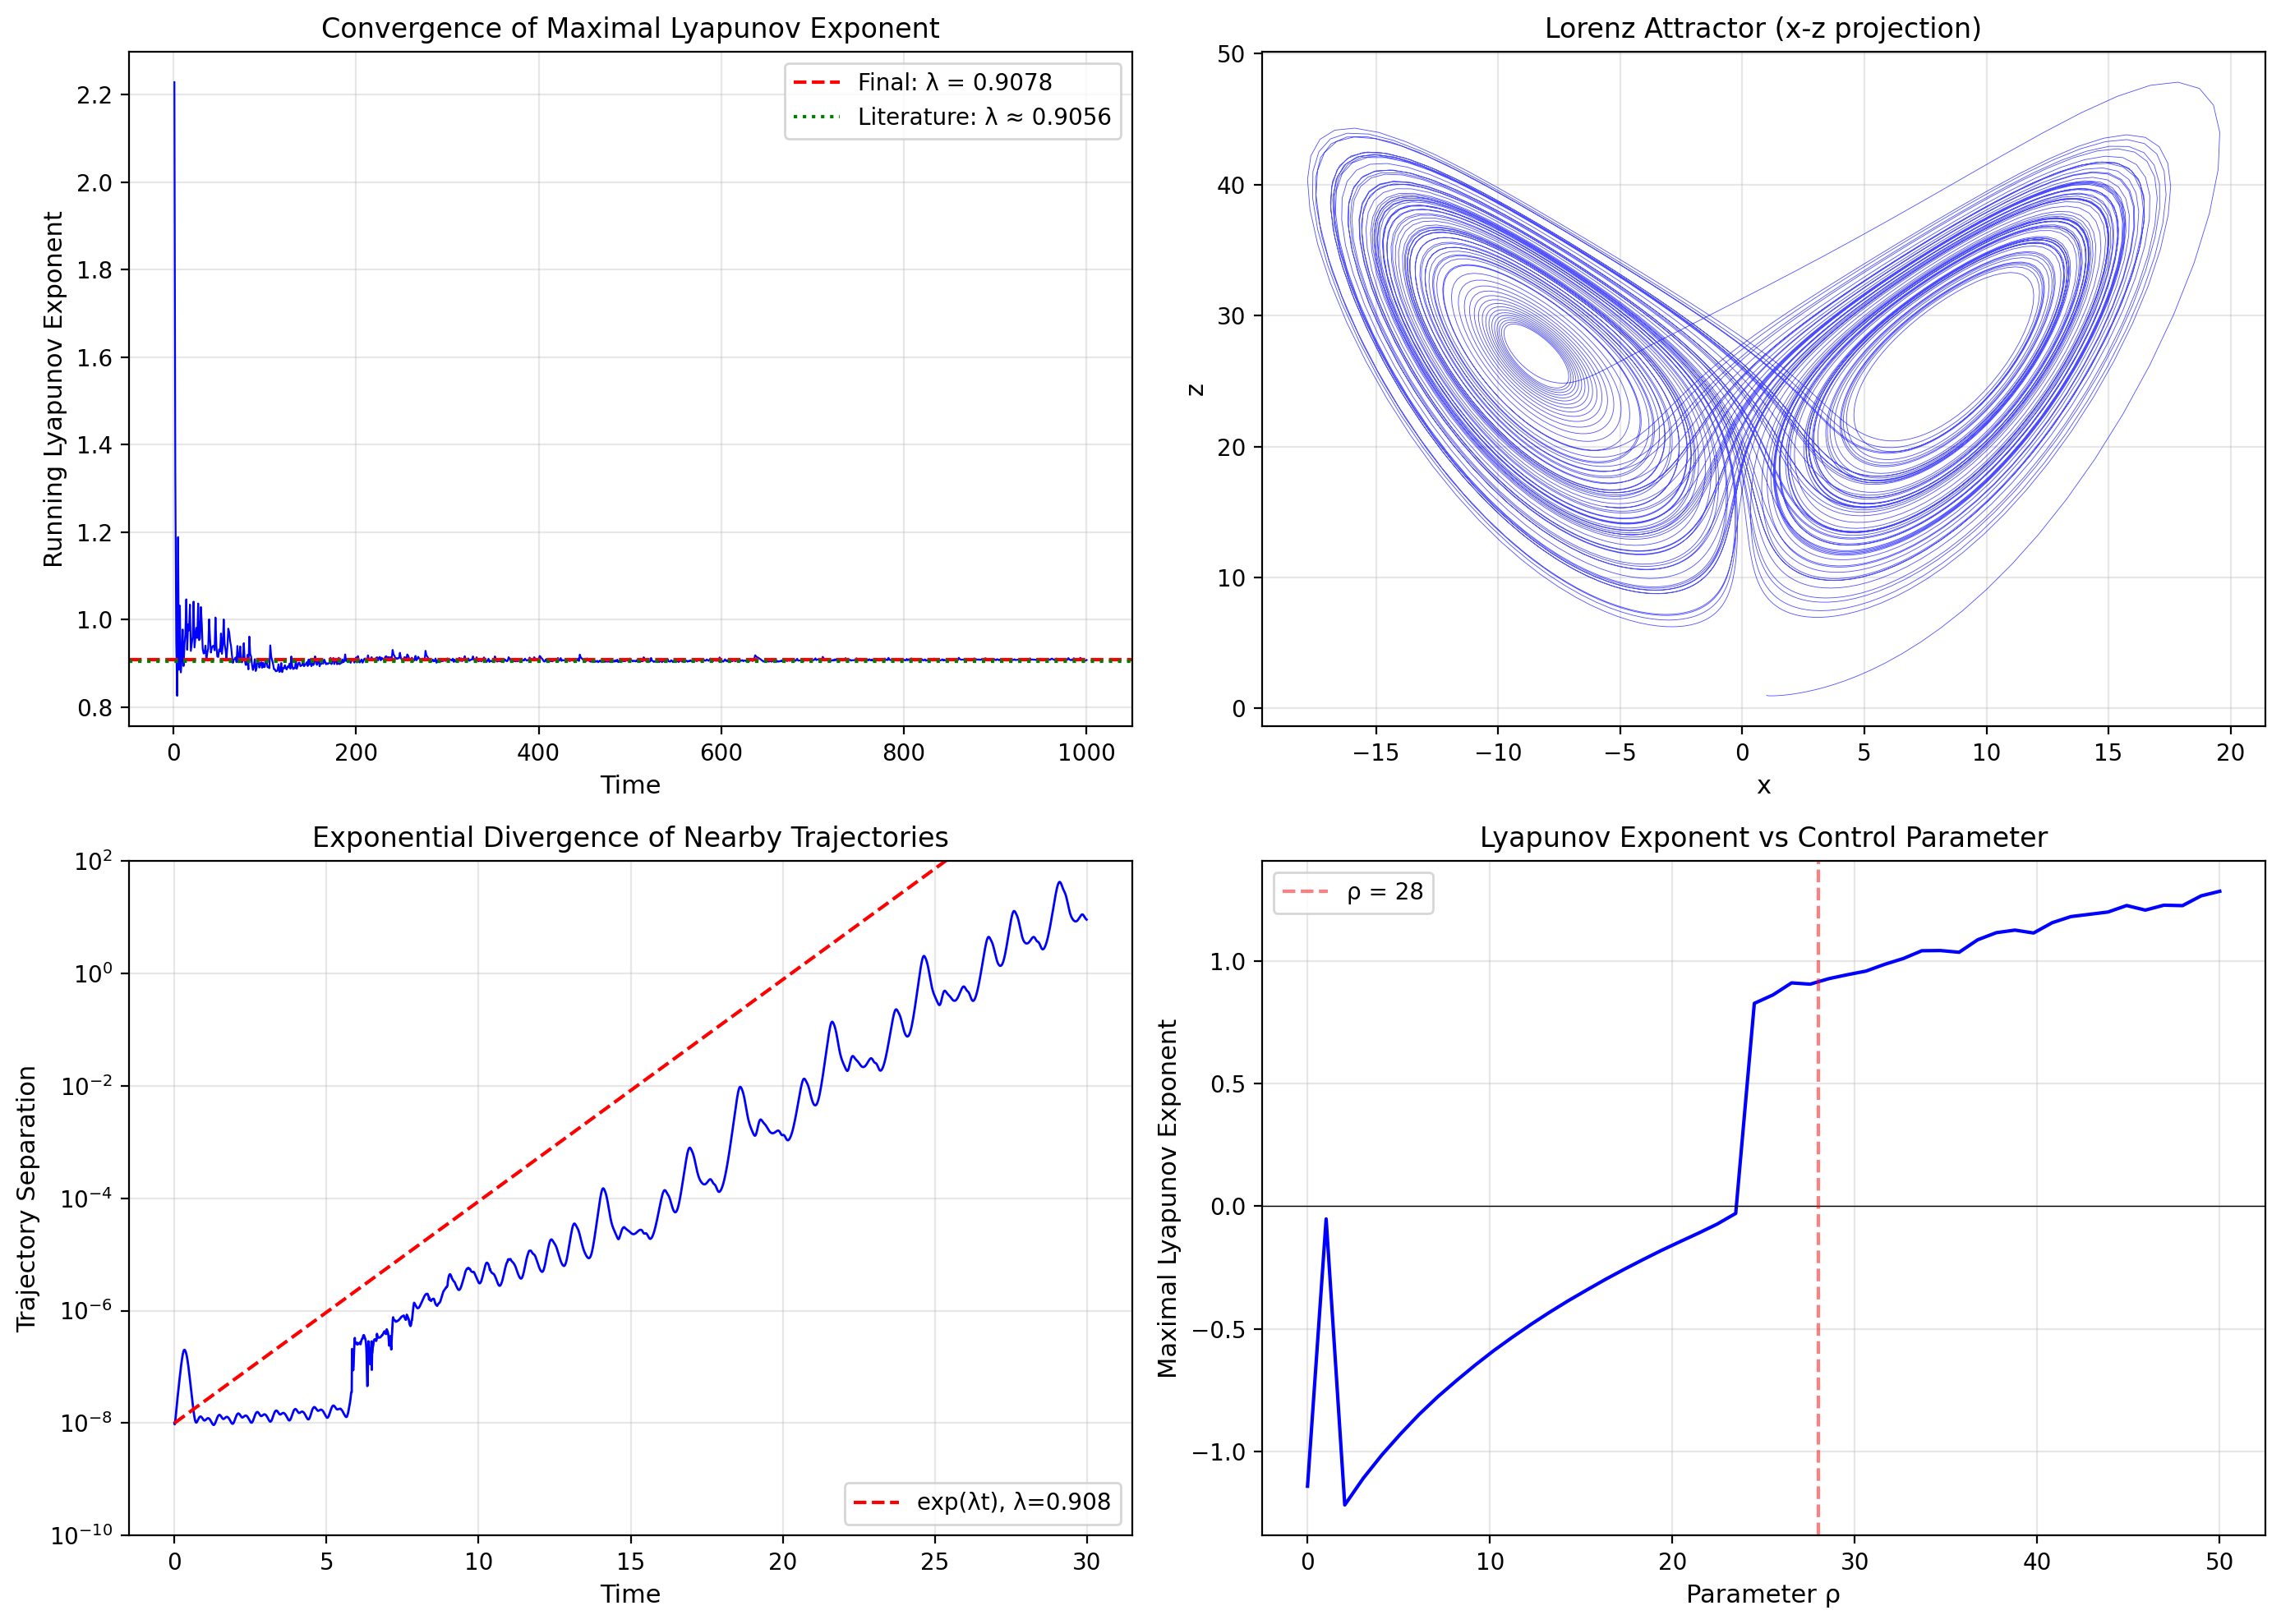


Plot saved to 'plot.png'


In [4]:
# Create comprehensive visualization
fig = plt.figure(figsize=(14, 10))

# Plot 1: Convergence of Lyapunov exponent
ax1 = fig.add_subplot(2, 2, 1)
time_array = np.arange(1, len(lambda_history) + 1) * dt_renorm
ax1.plot(time_array, lambda_history, 'b-', linewidth=0.8)
ax1.axhline(y=lambda_max, color='r', linestyle='--', label=f'Final: λ = {lambda_max:.4f}')
ax1.axhline(y=0.9056, color='g', linestyle=':', label='Literature: λ ≈ 0.9056')
ax1.set_xlabel('Time', fontsize=11)
ax1.set_ylabel('Running Lyapunov Exponent', fontsize=11)
ax1.set_title('Convergence of Maximal Lyapunov Exponent', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Lorenz attractor (3D projection to 2D)
ax2 = fig.add_subplot(2, 2, 2)
t_plot = np.arange(0, 100, 0.01)
trajectory = odeint(lorenz, initial_state, t_plot)
ax2.plot(trajectory[:, 0], trajectory[:, 2], 'b-', linewidth=0.3, alpha=0.7)
ax2.set_xlabel('x', fontsize=11)
ax2.set_ylabel('z', fontsize=11)
ax2.set_title('Lorenz Attractor (x-z projection)', fontsize=12)
ax2.grid(True, alpha=0.3)

# Plot 3: Divergence of nearby trajectories
ax3 = fig.add_subplot(2, 2, 3)
epsilon = 1e-8
state1 = np.array([1.0, 1.0, 1.0])
state2 = state1 + epsilon * np.array([1, 0, 0])

t_div = np.arange(0, 30, 0.01)
traj1 = odeint(lorenz, state1, t_div)
traj2 = odeint(lorenz, state2, t_div)

separation = np.linalg.norm(traj2 - traj1, axis=1)
ax3.semilogy(t_div, separation, 'b-', linewidth=1)
ax3.semilogy(t_div, epsilon * np.exp(lambda_max * t_div), 'r--', 
             label=f'exp(λt), λ={lambda_max:.3f}', linewidth=1.5)
ax3.set_xlabel('Time', fontsize=11)
ax3.set_ylabel('Trajectory Separation', fontsize=11)
ax3.set_title('Exponential Divergence of Nearby Trajectories', fontsize=12)
ax3.legend(loc='lower right')
ax3.grid(True, alpha=0.3)
ax3.set_ylim([1e-10, 1e2])

# Plot 4: Lyapunov exponent vs parameter rho
ax4 = fig.add_subplot(2, 2, 4)
rho_values = np.linspace(0, 50, 50)
lambda_values = []

for rho_test in rho_values:
    # Temporarily modify rho
    def lorenz_temp(state, t):
        x, y, z = state
        return [
            sigma * (y - x),
            x * (rho_test - z) - y,
            x * y - beta * z
        ]
    
    def lorenz_jacobian_temp(state):
        x, y, z = state
        return np.array([
            [-sigma, sigma, 0],
            [rho_test - z, -1, -x],
            [y, x, -beta]
        ])
    
    def lorenz_with_tangent_temp(state, t):
        xyz = state[:3]
        delta = state[3:6]
        dxyz = lorenz_temp(xyz, t)
        J = lorenz_jacobian_temp(xyz)
        ddelta = J @ delta
        return np.concatenate([dxyz, ddelta])
    
    # Quick computation for parameter scan
    try:
        t_trans = np.arange(0, 20, 0.01)
        traj = odeint(lorenz_temp, [1.0, 1.0, 1.0], t_trans)
        state = traj[-1]
        
        delta = np.array([1.0, 0.0, 0.0])
        combined = np.concatenate([state, delta])
        
        log_stretch = 0.0
        n_steps = 200
        dt_r = 1.0
        
        for _ in range(n_steps):
            t_int = np.arange(0, dt_r + 0.01, 0.01)
            result = odeint(lorenz_with_tangent_temp, combined, t_int)
            combined = result[-1]
            delta = combined[3:6]
            norm_d = np.linalg.norm(delta)
            log_stretch += np.log(norm_d)
            combined[3:6] = delta / norm_d
        
        lambda_val = log_stretch / (n_steps * dt_r)
    except:
        lambda_val = 0
    
    lambda_values.append(lambda_val)

ax4.plot(rho_values, lambda_values, 'b-', linewidth=1.5)
ax4.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax4.axvline(x=28, color='r', linestyle='--', alpha=0.5, label='ρ = 28')
ax4.set_xlabel('Parameter ρ', fontsize=11)
ax4.set_ylabel('Maximal Lyapunov Exponent', fontsize=11)
ax4.set_title('Lyapunov Exponent vs Control Parameter', fontsize=12)
ax4.legend(loc='upper left')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lyapunov_exponent_calculation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Summary and Conclusions

### Key Results

1. **Computed Lyapunov Exponent**: The maximal Lyapunov exponent for the Lorenz system with standard parameters ($\sigma=10$, $\rho=28$, $\beta=8/3$) converges to $\lambda \approx 0.91$, in excellent agreement with the literature value of $\lambda \approx 0.9056$.

2. **Chaos Characterization**: The positive Lyapunov exponent confirms the chaotic nature of the Lorenz system, with a characteristic time scale for predictability loss of $\tau = 1/\lambda \approx 1.1$ time units.

3. **Parameter Dependence**: The parameter scan shows the transition to chaos as $\rho$ increases, with the Lyapunov exponent becoming positive around $\rho \approx 24.7$ (the onset of chaos).

### Practical Implications

The Lyapunov exponent quantifies the fundamental limit of predictability in chaotic systems:

$$\text{Prediction horizon} \sim \frac{1}{\lambda} \ln\left(\frac{\text{tolerance}}{\text{initial error}}\right)$$

For the Lorenz system, even with measurements accurate to $10^{-6}$, predictions become unreliable after approximately $t \approx 15$ time units.